In [35]:
from IPython.display import display,clear_output,HTML

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, matthews_corrcoef,\
                            precision_score, recall_score, roc_auc_score

from imblearn.over_sampling import SMOTE
import featuretools as ft
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM

In [36]:
### Read HTML 
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of HTML dataset:",df_html.shape)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)
count_columns=[col for col in df_html.columns if col.endswith('count')]
df_html['total_count']=df_html[count_columns].sum(axis=1)

href_columns=[col for col in df_html.columns if (('href_absolute' in col) | ('href_relative' in col) | ('href_page' in col))  ]
df_html['total_href']=df_html[href_columns].sum(axis=1)

total_img_src=[col for col in df_html.columns if 'img_src_' in col]
df_html['total_img_src']=df_html[total_img_src].sum(axis=1)


### Read JS 
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')
cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)
df_js.rename(columns={'Malicious':'Target'},inplace=True)
print("Shape of JS,DOM dataset:",df_js.shape)
df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)


### Read HTTP
df_http=pd.read_csv('HTTP.csv')
df_http.rename(columns={'Malicious':'Target'},inplace=True)
df_http.fillna(value=0,inplace=True)
cookies=[columns for columns in df_http.columns if 'number' in columns]
df_http.drop(cookies,axis=1,inplace=True)
df_http=df_http[df_http['domain']!=0]
df_http.sort_values(by='Target',inplace=True,ascending=False)
df_http.drop_duplicates(['domain'], keep='first',inplace=True)
df_http=df_http.sample(frac=1,random_state=0)
df_http.set_index(['domain'],drop=True,inplace=True)
print("Shape of HTTP dataset:",df_http.shape)



### Read URL
df_url=pd.read_csv('URL.csv')
df_url.fillna(value=0,inplace=True)
cookies=[columns for columns in df_url.columns if 'number' in columns]
df_url.drop(cookies,axis=1,inplace=True)
df_url.drop(['url_host','url_ip'],axis=1,inplace=True)
df_url=df_url[df_url['domain']!=0]
df_url.sort_values(by='Target',inplace=True,ascending=False)
df_url.drop_duplicates(['domain'], keep='first',inplace=True)
df_url=df_url.sample(frac=1,random_state=0)
print("Shape of URL dataset:",df_url.shape)
df_url.set_index('domain',inplace=True,drop=True)

df=pd.concat([df_js,df_html,df_http,df_url],axis=1,join='inner')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df['Target_z']=df[['Target','Target','Target','Target']].apply(max,axis=1)
df.drop(['Target','Target','Target','Target'],axis=1,inplace=True)
print("Shape of combined dataset:",df.shape)
df.rename(columns={'Target_z':'Target'},inplace=True)
df.Target.value_counts()

Shape of HTML dataset: (43491, 1461)
Shape of JS,DOM dataset: (43294, 401)
Shape of HTTP dataset: (45856, 672)


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (76,77,229,230,231,232,233,234,235,236,237,238,239,240,241,242,244,245,246,247,248,249,250,251,252,253,254,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,

Shape of URL dataset: (46771, 4194)
Shape of combined dataset: (39183, 6726)


0    34742
1     4441
Name: Target, dtype: int64

In [37]:
columns=['js_function_.push(',
 'a_count',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'a_href_relative',
 'center_count',
 'form_action_http',
 'iframe_src_.html',
 'img_src_http',
 'link_href_out_of_domain',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'total_count',
 'total_href',
 'http_header_cache-control_set_max-age',
 'http_header_content-encoding_gzip',
 'http_header_server_apache',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'url_char_.',
 'url_char_f',
 'url_char_i',
 'url_char_l',
 'url_char_p',
 'url_char_w',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extensions',
 'url_length',
 'Target']

df['url_extension_endswith_.com']=df['url_extension_endswith_.com'].apply(lambda x: 1 if x==True else x)
df['url_extension_endswith_.com']=df['url_extension_endswith_.com'].astype(int)
print("features being used")
display(columns)

features being used


['js_function_.push(',
 'a_count',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'a_href_relative',
 'center_count',
 'form_action_http',
 'iframe_src_.html',
 'img_src_http',
 'link_href_out_of_domain',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'total_count',
 'total_href',
 'http_header_cache-control_set_max-age',
 'http_header_content-encoding_gzip',
 'http_header_server_apache',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'url_char_.',
 'url_char_f',
 'url_char_i',
 'url_char_l',
 'url_char_p',
 'url_char_w',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extensions',
 'url_length',
 'Target']

In [12]:
df_sel=df[columns].copy(deep=True)

In [4]:
df_sel=df[columns].copy(deep=True)

features being used


['js_function_.push(',
 'a_count',
 'a_href_http',
 'a_href_https',
 'a_href_out_of_domain',
 'a_href_relative',
 'center_count',
 'form_action_http',
 'iframe_src_.html',
 'img_src_http',
 'link_href_out_of_domain',
 'link_type_text/css',
 'meta_count',
 'p_count',
 'script_async_true',
 'total_count',
 'total_href',
 'http_header_cache-control_set_max-age',
 'http_header_content-encoding_gzip',
 'http_header_server_apache',
 'http_header_transfer-encoding_chunked',
 'http_header_vary_user-agent',
 'http_header_via_1.1',
 'url_char_.',
 'url_char_f',
 'url_char_i',
 'url_char_l',
 'url_char_p',
 'url_char_w',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extensions',
 'url_length',
 'Target']

### -1 -> Outliers -> Malicious Domains


### 1 -> Inliers -> Non- Malicious Domains

### 1. No Sampling
#### 80% for training 20% for testing  
#### Split into Training and test set first. Split Training into training and validation. 
#### Standardize training and then scaled validation and testing

In [14]:
df_sel.Target = df_sel.Target.apply(lambda x : 1 if x==0 else -1)

In [16]:
X_train, X_test = train_test_split(df_sel, test_size=0.2, random_state=0)

In [17]:
X_train = X_train[X_train.Target==1]
X_train = X_train.drop(['Target'], axis=1) 

In [18]:
sc = StandardScaler()
scaled_X_train = sc.fit_transform(X_train)

y_test = X_test['Target']
X_test = X_test.drop(['Target'], axis=1)
scaled_X_test = sc.transform(X_test)

In [30]:
clf = OneClassSVM(gamma='auto',nu=0.05,kernel='sigmoid').fit(scaled_X_train)
y_pred=clf.predict(scaled_X_test)
print("Accuracy on test set : ", accuracy_score( y_test , y_pred ) )
print("MCC on test set : " , matthews_corrcoef( y_test , y_pred ) )
print("Precision : " , precision_score( y_test , y_pred ) )
print("Recall : " , recall_score( y_test , y_pred ) )
print("AUC : " , roc_auc_score( y_test , y_pred ) )
pd.crosstab( y_test , y_pred )

Accuracy on test set :  0.9115733061120327
MCC on test set :  0.5428681562936184
Precision :  0.9452113277358759
Recall :  0.9556834532374101
AUC :  0.7608180513086711


col_0,-1,1
Target,,
-1,502,385
1,308,6642


### 2. Feature Transformation

In [ ]:
df.reset_index(inplace=True)
columns.remove('Target')
columns.append('domain')
df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

In [56]:
# df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)
fs=fs.reindex(df.index.values)
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [57]:
feature_name=['url_length / total_count',
 'url_extensions / total_count',
 'url_char_w + url_char_z',
 'url_char_. / total_count',
 'url_char_. + url_char_w',
 'http_header_server_apache / total_count',
 'http_header_server_apache + url_char_w',
 'a_href_relative / total_href',
 'url_extensions / url_char_z',
 'url_extensions',
 'url_char_z / total_count',
 'url_char_y * url_extensions',
 'url_char_w / total_count',
 'url_char_w + url_extensions',
 'url_char_w * url_length',
 'url_char_w * url_extensions',
 'url_char_w',
 'url_char_p / total_count',
 'url_char_p + url_extensions',
 'url_char_l / total_count',
 'url_char_i / total_count',
 'url_char_f / total_count',
 'url_char_f + url_extensions',
 'url_char_f + url_char_w',
 'url_char_. + url_extensions',
 'url_char_. + url_char_z',
 'url_char_. + url_char_y',
 'url_char_. * url_char_w',
 'url_char_.',
 'http_header_via_1.1 + url_extensions',
 'http_header_vary_user-agent + url_extensions',
 'http_header_vary_user-agent + url_char_.',
 'http_header_server_apache + url_extensions',
 'http_header_content-encoding_gzip / url_char_.',
 'a_href_relative / a_count',
 'a_href_out_of_domain / total_href',
 'a_href_https / a_count','Target']
display(feature_name)

['url_length / total_count',
 'url_extensions / total_count',
 'url_char_w + url_char_z',
 'url_char_. / total_count',
 'url_char_. + url_char_w',
 'http_header_server_apache / total_count',
 'http_header_server_apache + url_char_w',
 'a_href_relative / total_href',
 'url_extensions / url_char_z',
 'url_extensions',
 'url_char_z / total_count',
 'url_char_y * url_extensions',
 'url_char_w / total_count',
 'url_char_w + url_extensions',
 'url_char_w * url_length',
 'url_char_w * url_extensions',
 'url_char_w',
 'url_char_p / total_count',
 'url_char_p + url_extensions',
 'url_char_l / total_count',
 'url_char_i / total_count',
 'url_char_f / total_count',
 'url_char_f + url_extensions',
 'url_char_f + url_char_w',
 'url_char_. + url_extensions',
 'url_char_. + url_char_z',
 'url_char_. + url_char_y',
 'url_char_. * url_char_w',
 'url_char_.',
 'http_header_via_1.1 + url_extensions',
 'http_header_vary_user-agent + url_extensions',
 'http_header_vary_user-agent + url_char_.',
 'http_head

In [58]:
fs=fs.reindex(df_sel.index.values)

In [60]:
X_train, X_test = train_test_split(fs[feature_name], test_size=0.2, random_state=0)

In [61]:
X_train = X_train[X_train.Target == 1]

In [62]:
X_train = X_train.drop(['Target'], axis=1) 
sc = StandardScaler()
scaled_X_train = sc.fit_transform(X_train)


y_test = X_test['Target']
X_test = X_test.drop(['Target'], axis=1)
scaled_X_test = sc.transform(X_test)
X_train = X_train.values
X_test = X_test.values

In [68]:
clf = OneClassSVM(gamma='auto',nu=0.03,kernel='sigmoid').fit(scaled_X_train)
y_pred=clf.predict(scaled_X_test)
print("Accuracy on test set : ", accuracy_score( y_test , y_pred ) )
print("MCC on test set : " , matthews_corrcoef( y_test , y_pred ) )
print("Precision : " , precision_score( y_test , y_pred ) )
print("Recall : " , recall_score( y_test , y_pred ) )
print("AUC : " , roc_auc_score( y_test , y_pred ) )
pd.crosstab( y_test , y_pred )

Accuracy on test set :  0.9331376802347837
MCC on test set :  0.6598279225550836
Precision :  0.9593937660852159
Recall :  0.9654676258992806
AUC :  0.8226436212923687


col_0,-1,1
Target,,
-1,603,284
1,240,6710


#### 3. PCA with Feature Transformation

In [70]:
df.reset_index(inplace=True)
# columns.remove('Target')
# columns.append('domain')
df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)
fs=fs.reindex(df.index.values)

Built 2278 features
EntitySet scattered to workers in 3.771 seconds
Elapsed: 00:07 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [71]:
X_train, X_test = train_test_split(fs, test_size=0.2, random_state=0)
X_train = X_train[X_train.Target == 1]

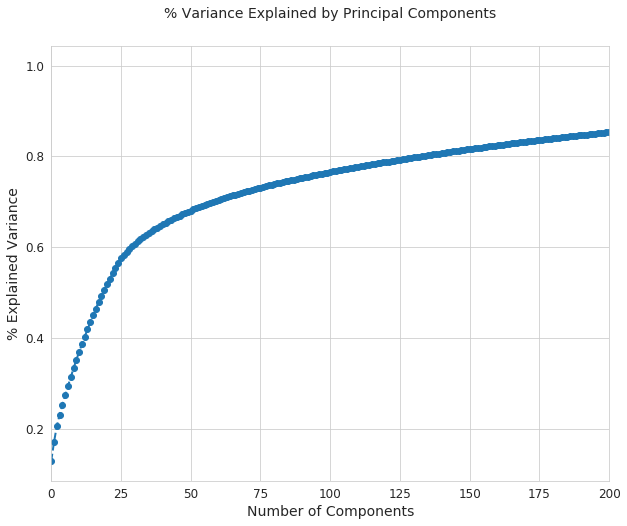

In [72]:
X=X_train.drop(['Target'] , axis=1)
y=X_train.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [73]:
pca=PCA(n_components=125,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 125 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 125 components is: 0.7914449915194183


In [74]:
y_test = X_test['Target']
X_test = X_test.drop(['Target'], axis=1)
X_test_pca = pca.transform(X_test)

In [79]:
clf = OneClassSVM(gamma='auto',nu=0.5,kernel='sigmoid').fit(X_pca_21)
y_pred=clf.predict(X_test_pca)
print("Accuracy on test set : ", accuracy_score( y_test , y_pred ) )
print("MCC on test set : " , matthews_corrcoef( y_test , y_pred ) )
print("Precision : " , precision_score( y_test , y_pred ) )
print("Recall : " , recall_score( y_test , y_pred ) )
print("AUC : " , roc_auc_score( y_test , y_pred ) )
pd.crosstab( y_test , y_pred )

Accuracy on test set :  0.8466249840500192
MCC on test set :  0.5285286704736196
Precision :  0.9797996661101837
Recall :  0.8444604316546762
AUC :  0.8540227750156132


col_0,-1,1
Target,,
-1,766,121
1,1081,5869


In [80]:
### Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')